# Import aller Bibliotheken + Frameworks

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Datenimport

In [2]:
#pd.set_option('display.max_rows', 100)

# Übergabe des RAW-URL von Github -> DAILY
url_data_daily = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-31-2022.csv')
data_daily_world = pd.read_csv(url_data_daily)

# Lade CSV aus Ordner -> TIME SERIES (from John Hopkins University)
data_TS_world = pd.read_csv('COVID-19-time-series-clean-complete.csv')

# 2. Data Processing - TIME SERIES

#### Die Tabelle "data_TS_world" beinhaltet die Zeitreihen aller Länder weltweit -> positive Covid-Fälle + Todesfälle

In [3]:
data_TS_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169617 entries, 0 to 169616
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      169617 non-null  int64  
 1   Date            169617 non-null  object 
 2   Country/Region  169617 non-null  object 
 3   Confirmed       169617 non-null  int64  
 4   Deaths          169617 non-null  int64  
 5   Recovered       169617 non-null  float64
 6   Active          169617 non-null  float64
 7   New cases       169617 non-null  int64  
 8   New deaths      169617 non-null  int64  
 9   New recovered   169617 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 12.9+ MB


## <p style="color:Tomato;">TEST => Tabelle "data_TS_world" nach Deutschland gefiltert und in einem LineGraph dargestellt</p>

In [4]:
# alle Werte zu Deutschland
data_TS_world_Germany = data_TS_world[data_TS_world['Country/Region'] == "Germany"]

In [5]:
x_date = data_TS_world_Germany['Date']
y_deaths = data_TS_world_Germany['New deaths']

C:\ProgramData\Anaconda3\envs\dash\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


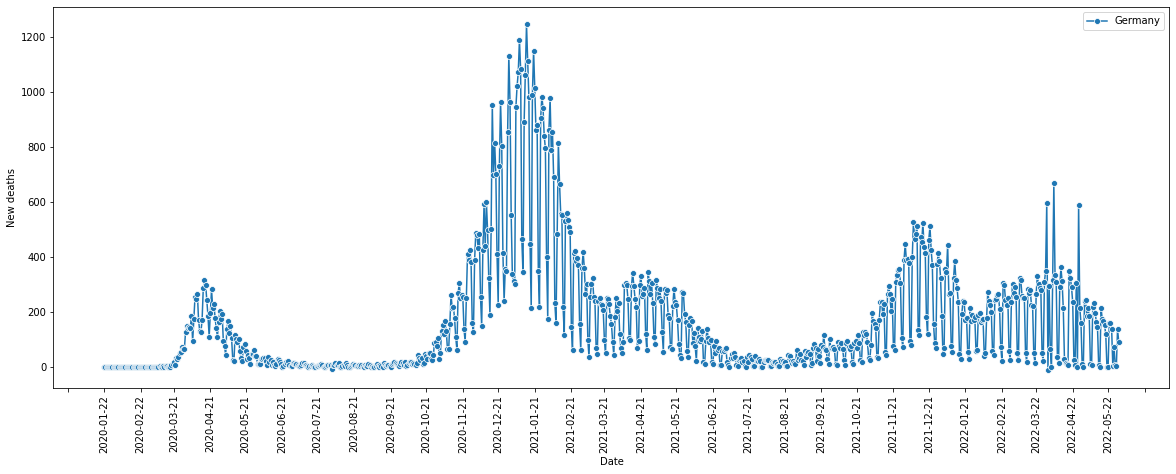

In [6]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m') #This is a format. Will be clear in Screenshot

fig, axes = plt.subplots(figsize=(20,7))

sns.lineplot(x_date, y_deaths, label = 'Germany', marker = 'o')

axes.xaxis.set_major_locator(months)
#axes.xaxis.set_major_formatter(years_fmt)
#axes.xaxis.set_minor_locator(months)

plt.xticks(rotation = 'vertical')
plt.show()

## 2.1. Join -> Fälle + Impfungen

In [7]:
# Cases -> Namensänderungen
data_TS_world = data_TS_world.drop(['Unnamed: 0'], axis=1)
data_TS_world = data_TS_world.rename(columns={"Country/Region":"Country_Region", "Confirmed":"Confirmed_Cases", "New cases":"New_Cases", "New deaths":"New_Deaths", "New recovered":"New_Recovered"})

In [8]:
# Daten der Impfungen werden geladen
data_TS_world_doses = pd.read_csv('time_series_covid19_vaccine_global.csv')

# Spalten entfernen
data_TS_world_doses = data_TS_world_doses.drop(["Report_Date_String", "UID"], axis=1)

# filtern nach Zeilen mit "Province_State = NaN" => es handelt sich um die Gesamtzahl/Country/Tag (keine Provinzen!)
data_TS_world_doses = data_TS_world_doses[data_TS_world_doses['Province_State'].isna()]

In [9]:
# Join -> Cases-Tabelle + Impfungen-Tabelle
full_table_world = data_TS_world.merge(
    right = data_TS_world_doses,
    how = 'left',
    on = ['Country_Region', 'Date'],
    indicator=True   # adds a new column "_merge" -> values: left_only OR right_only OR both
)

#full_table_world.shape

#### Die Tabelle "full_table_world" beinhaltet alle Covid- und Impf-Daten. 

In [10]:
# Entfernen von Spalten
full_table_world = full_table_world.drop(["People_partially_vaccinated", "People_fully_vaccinated"], axis=1)

In [11]:
# Spalte "Date" wird von String- ins Date-Format umgewandelt
full_table_world['Date'] = pd.to_datetime(full_table_world['Date'])

## 2.2 Join -> Population mit Tabelle "GDP_and_pop_by_country"

In [12]:
# Tabelle mit GDP und Populationen laden (vom IWF)
GDP_pop_world = pd.read_csv('GDP_and_pop_by_country.csv')

In [13]:
# diverse Namensanpassungen
GDP_pop_world = GDP_pop_world[{'country', 'imfGDP', 'pop'}]
GDP_pop_world = GDP_pop_world.rename(columns={"imfGDP":"GDP", "pop":"Population", "country":"Country_Region"})

# GDP = BIP vom Internationalen Währungsfond 2019
# Population 2019

GDP_pop_world = GDP_pop_world.replace("United States", "US")
GDP_pop_world = GDP_pop_world.replace("Czech Republic", "Czechia")
GDP_pop_world = GDP_pop_world.replace("South Korea", "Korea, South")

In [14]:
# CHeck am Beispiel "China"
GDP_pop_world[GDP_pop_world['Country_Region']=="China"]

,Country_Region,Population,GDP
1,China,1448471.4,1.546810e+13


In [15]:
# Spalte "_merge" entfernen
full_table_world = full_table_world.drop(["_merge"], axis=1)

# Join mit full_table_world
full_table_world_final = full_table_world.merge(
    right = GDP_pop_world,
    how = 'left',
    on = 'Country_Region',
    indicator=True   # fügt Spalte "_merge" hinzu -> values: left_only OR right_only OR both
)

#full_table_world_final.shape

In [16]:
# Werte der fehlerhaften Länderbezeichnungen ausgeben
test = full_table_world_final[full_table_world_final["_merge"]=="left_only"]

list_wrong_countries = test["Country_Region"].tolist()

myset = set(list_wrong_countries)
mynewlist = list(myset)
mynewlist

['Burma',
 'Winter Olympics 2022',
 'Summer Olympics 2020',
 'Antarctica',
 'Holy See',
 'Korea, North',
 'Congo (Kinshasa)',
 'Kosovo',
 'Cabo Verde',
 'Congo (Brazzaville)',
 'West Bank and Gaza',
 'Taiwan*',
 "Cote d'Ivoire"]

In [17]:
full_table_world_final[full_table_world_final['Country_Region'] == "China"][:602]

,Date,Country_Region,Confirmed_Cases,Deaths,Recovered,Active,New_Cases,New_Deaths,New_Recovered,Doses_admin,Province_State,Population,GDP,_merge
37,2020-01-22,China,548,17,28.0,503.0,0,0,0,NaN,NaN,1448471.4,1.546810e+13,both
234,2020-01-23,China,643,18,30.0,595.0,95,1,2,NaN,NaN,1448471.4,1.546810e+13,both
431,2020-01-24,China,920,26,36.0,858.0,277,8,6,NaN,NaN,1448471.4,1.546810e+13,both
628,2020-01-25,China,1406,42,39.0,1325.0,486,16,3,NaN,NaN,1448471.4,1.546810e+13,both
825,2020-01-26,China,2075,56,49.0,1970.0,669,14,10,NaN,NaN,1448471.4,1.546810e+13,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117646,2021-09-10,China,118371,4848,0.0,113523.0,50,0,0,2.129833e+09,NaN,1448471.4,1.546810e+13,both
117843,2021-09-11,China,118437,4848,0.0,113589.0,66,0,0,2.135240e+09,NaN,1448471.4,1.546810e+13,both
118040,2021-09-12,China,118528,4848,0.0,113680.0,91,0,0,2.148120e+09,NaN,1448471.4,1.546810e+13,both
118237,2021-09-13,China,118646,4849,0.0,113797.0,118,1,0,2.152520e+09,NaN,1448471.4,1.546810e+13,both


# 3. Finale Tabelle erstellen

In [18]:
# Namensänderungen von Spalten
full_table_world_final = full_table_world_final.rename(columns={"Country_Region":"Country"})

# Spalte "_merge" entfernen
full_table_world_final = full_table_world_final.drop(["_merge"], axis=1)

# NaN to 0
full_table_world_final['Population'] = full_table_world_final['Population'].fillna(0)
full_table_world_final['Doses_admin'] = full_table_world_final['Doses_admin'].fillna(0)

# Kommas aufheben
full_table_world_final['Population'] = full_table_world_final['Population'] * 1000

# Casting -> float zu int
#full_table_world_final['Doses_admin'] = full_table_world_final['Doses_admin'].astype(int)
full_table_world_final['Population'] = full_table_world_final['Population'].astype(int)

# Kalukaltionen:
# relative KPIs
full_table_world_final['Confirmed_Cases_rel'] = (full_table_world_final['Confirmed_Cases']*100) / full_table_world_final['Population']
full_table_world_final['Deaths_rel'] = (full_table_world_final['Deaths']*100) / full_table_world_final['Population']

# Doses_admin / 100 Einwohner
full_table_world_final['Doses_admin_per_100'] = full_table_world_final['Doses_admin'] / (full_table_world_final['Population']/100) 

# GDP pro Kopf
full_table_world_final['GDP_pro_Kopf'] = full_table_world_final['GDP'] / full_table_world_final['Population']

In [19]:
# finale Tabelle am Beispiel "Germany"
germany = full_table_world_final[full_table_world_final['Country']=='Germany']
germany

,Date,Country,Confirmed_Cases,Deaths,Recovered,Active,New_Cases,New_Deaths,New_Recovered,Doses_admin,Province_State,Population,GDP,Confirmed_Cases_rel,Deaths_rel,Doses_admin_per_100,GDP_pro_Kopf
66,2020-01-22,Germany,0,0,0.0,0.0,0,0,0,0.0,NaN,83883596,4.157120e+12,0.000000,0.000000,0.000000,49558.199675
263,2020-01-23,Germany,0,0,0.0,0.0,0,0,0,0.0,NaN,83883596,4.157120e+12,0.000000,0.000000,0.000000,49558.199675
460,2020-01-24,Germany,0,0,0.0,0.0,0,0,0,0.0,NaN,83883596,4.157120e+12,0.000000,0.000000,0.000000,49558.199675
657,2020-01-25,Germany,0,0,0.0,0.0,0,0,0,0.0,NaN,83883596,4.157120e+12,0.000000,0.000000,0.000000,49558.199675
854,2020-01-26,Germany,0,0,0.0,0.0,0,0,0,0.0,NaN,83883596,4.157120e+12,0.000000,0.000000,0.000000,49558.199675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168698,2022-05-27,Germany,26240639,138854,0.0,26101785.0,39976,73,0,179951244.0,NaN,83883596,4.157120e+12,31.282206,0.165532,214.524952,49558.199675
168895,2022-05-28,Germany,26243352,138862,0.0,26104490.0,2713,8,0,179951244.0,NaN,83883596,4.157120e+12,31.285440,0.165541,214.524952,49558.199675
169092,2022-05-29,Germany,26244107,138864,0.0,26105243.0,755,2,0,179961747.0,NaN,83883596,4.157120e+12,31.286340,0.165544,214.537473,49558.199675
169289,2022-05-30,Germany,26305996,139000,0.0,26166996.0,61889,136,0,179988058.0,NaN,83883596,4.157120e+12,31.360120,0.165706,214.568839,49558.199675


In [20]:
dashboard_time_series_complete = full_table_world_final

In [21]:
# Spalten entfernen
dashboard_time_series_complete = dashboard_time_series_complete.drop(["Recovered", "Active", "New_Recovered", "Province_State"], axis=1)

# alle Zeilen mit NaN-Werten entfernen
dashboard_time_series_complete['Population'] = dashboard_time_series_complete['Population'].dropna()
dashboard_time_series_complete = dashboard_time_series_complete.dropna()

In [22]:
dashboard_time_series_complete

,Date,Country,Confirmed_Cases,Deaths,New_Cases,New_Deaths,Doses_admin,Population,GDP,Confirmed_Cases_rel,Deaths_rel,Doses_admin_per_100,GDP_pro_Kopf
0,2020-01-22,Afghanistan,0,0,0,0,0.0,40754388,2.068200e+10,0.000000,0.000000,0.000000,507.479096
1,2020-01-22,Albania,0,0,0,0,0.0,2866374,1.721000e+10,0.000000,0.000000,0.000000,6004.101349
2,2020-01-22,Algeria,0,0,0,0,0.0,45350148,1.930560e+11,0.000000,0.000000,0.000000,4257.009260
3,2020-01-22,Andorra,0,0,0,0,0.0,77463,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,2020-01-22,Angola,0,0,0,0,0.0,35027343,9.642600e+10,0.000000,0.000000,0.000000,2752.877945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169610,2022-05-31,Venezuela,523654,5721,36,0,37860994.0,29266991,7.010600e+10,1.789231,0.019548,129.364150,2395.394867
169611,2022-05-31,Vietnam,10719379,43079,1010,1,220779518.0,98953541,2.823720e+11,10.832739,0.043535,223.114318,2853.581561
169614,2022-05-31,Yemen,11822,2149,0,0,836455.0,31154867,3.138500e+10,0.037946,0.006898,2.684829,1007.386743
169615,2022-05-31,Zambia,321779,3987,276,2,3478542.0,19470234,2.527200e+10,1.652671,0.020477,17.865949,1297.981319


## 3.1. Join -> mit GNI (Bruttonationaleinkommen)

In [23]:
# Tabelle mit GNI laden (von World Bank)
GNI_world = pd.read_csv("GNI_world.csv")

In [24]:
# Spalten filtern und umbenennen
GNI_world = GNI_world[{'Country Name', '2019'}]
GNI_world = GNI_world.rename(columns={"Country Name":"Country", "2019":"GNI_2019"})

# Klassifizierung der Länder nach Income_Group (siehe World Bank)

# Konditionen für Klassifizierung nach Income 
conditions = [
    (GNI_world['GNI_2019'] < 1046),
    (GNI_world['GNI_2019'] >= 1046) & (GNI_world['GNI_2019'] <= 4095),
    (GNI_world['GNI_2019'] > 4095) & (GNI_world['GNI_2019'] <= 12695),
    (GNI_world['GNI_2019'] > 12695)
    ]

values = ['Low', 'Lower-middle', 'Upper-middle', 'High']

GNI_world['Income group'] = np.select(conditions, values)

GNI_world

,GNI_2019,Country,Income group
0,NaN,Aruba,0
1,1535.776856,Africa Eastern and Southern,Lower-middle
2,520.000000,Afghanistan,Low
3,1669.153323,Africa Western and Central,Lower-middle
4,2970.000000,Angola,Lower-middle
...,...,...,...
261,4640.000000,Kosovo,Upper-middle
262,NaN,"Yemen, Rep.",0
263,6670.000000,South Africa,Upper-middle
264,1430.000000,Zambia,Lower-middle


In [25]:
# Join mit dashboard_time_series_complete
dashboard_time_series_complete = dashboard_time_series_complete.merge(
    right = GNI_world,
    how = 'left',
    on = 'Country',
    indicator=True   # fügt Spalte "_merge" hinzu -> values: left_only OR right_only OR both
)

In [26]:
# NaN to 0
dashboard_time_series_complete['GNI_2019'] = dashboard_time_series_complete['GNI_2019'].fillna(0)
dashboard_time_series_complete['Income group'] = dashboard_time_series_complete['Income group'].fillna(0)

## 3.2. Join -> mit Testungen

In [27]:
# Tabelle mit Testungen laden (aus Our World In Data)
Tests_world = pd.read_csv("testing-covid-data.csv")
Tests_world

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190727,ZWE,Africa,Zimbabwe,2022-05-27,251959.0,313.0,212.857,5500.0,2.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190728,ZWE,Africa,Zimbabwe,2022-05-28,251959.0,0.0,212.857,5500.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190729,ZWE,Africa,Zimbabwe,2022-05-29,252092.0,133.0,207.143,5500.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
190730,ZWE,Africa,Zimbabwe,2022-05-30,252092.0,0.0,198.571,5500.0,0.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [28]:
# Number of countries
Tests_world['location'].nunique()

244

In [29]:
# Datumsformat ändern
Tests_world["date"] = pd.to_datetime(Tests_world["date"])

In [30]:
# Spalten filtern und umbenennen
Tests_world = Tests_world[{'location', 'date', 'new_tests', 'total_tests'}]
Tests_world = Tests_world.rename(columns={"location":"Country", "date":"Date"})

In [31]:
# Join mit dashboard_time_series_complete
dashboard_time_series_complete = dashboard_time_series_complete.merge(
    right = Tests_world,
    how = 'left',
    on = ['Country', 'Date']
    #indicator=True   # fügt Spalte "_merge" hinzu -> values: left_only OR right_only OR both
)

In [32]:
# NaN to 0
dashboard_time_series_complete['new_tests'] = dashboard_time_series_complete['new_tests'].fillna(0)
dashboard_time_series_complete['total_tests'] = dashboard_time_series_complete['total_tests'].fillna(0)

# Spalte "_merge" entfernen
dashboard_time_series_complete = dashboard_time_series_complete.drop(["_merge"], axis=1)

In [33]:
# Kalukaltionen:
# relative KPIs
dashboard_time_series_complete['total_tests_rel'] = (dashboard_time_series_complete['total_tests']*100) / dashboard_time_series_complete['Population']

## 3.3. Export der finalen Tabelle

In [34]:
# finale Tabelle als CSV speichern
dashboard_time_series_complete.to_csv('dashboard_time_series_complete.csv')

In [35]:
dashboard_time_series_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158424 entries, 0 to 158423
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 158424 non-null  datetime64[ns]
 1   Country              158424 non-null  object        
 2   Confirmed_Cases      158424 non-null  int64         
 3   Deaths               158424 non-null  int64         
 4   New_Cases            158424 non-null  int64         
 5   New_Deaths           158424 non-null  int64         
 6   Doses_admin          158424 non-null  float64       
 7   Population           158424 non-null  int32         
 8   GDP                  158424 non-null  float64       
 9   Confirmed_Cases_rel  158424 non-null  float64       
 10  Deaths_rel           158424 non-null  float64       
 11  Doses_admin_per_100  158424 non-null  float64       
 12  GDP_pro_Kopf         158424 non-null  float64       
 13  GNI_2019      